# **Deep Learning Project: Street View Housing Number Digit Recognition**

# **Marks: 60**

--------------
## **Context**
--------------

One of the most interesting tasks in deep learning is to recognize objects in natural scenes. The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications.

The SVHN dataset contains over 600,000 labeled digits cropped from street-level photos. It is one of the most popular image recognition datasets. It has been used in neural networks created by Google to improve the map quality by automatically transcribing the address numbers from a patch of pixels. The transcribed number with a known street address helps pinpoint the location of the building it represents.

----------------
## **Objective**
----------------

Our objective is to predict the number depicted inside the image by using Artificial or Fully Connected Feed Forward Neural Networks and Convolutional Neural Networks. We will go through various models of each and finally select the one that is giving us the best performance.

-------------
## **Dataset**
-------------
Here, we will use a subset of the original data to save some computation time. The dataset is provided as a .h5 file. The basic preprocessing steps have been applied on the dataset.

## **Mount the drive**

Let us start by mounting the Google drive. You can run the below cell to mount the Google drive.

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing the necessary libraries**

In [51]:
# Importing libraries
import pandas as pd
import numpy as np

import tensorflow as tf
from keras import backend, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Input, Dropout, Flatten, BatchNormalization, LeakyReLU, MaxPooling2D

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import random
import h5py

from sklearn.model_selection import train_test_split

**Let us check the version of tensorflow.**

In [52]:
# Checking the version of Tensorflow
tf.__version__

'2.15.0'

## **Load the dataset**

- Let us now load the dataset that is available as a .h5 file.
- Split the data into the train and the test dataset.

In [53]:
H5_FILE_PATH = '/content/drive/MyDrive/MIT/Elective Project/SVHN_single_grey1.h5'

# Load file
dataset = h5py.File(H5_FILE_PATH, 'r')

# Set the image train and test datasets
X_train = dataset['X_train'][:]
X_test = dataset['X_test'][:]

# Set the label train and test datasets
y_train = dataset['y_train'][:]
y_test = dataset['y_test'][:]

Check the number of images in the training and the testing dataset.

In [54]:
X_train.shape, X_test.shape # getting the shape of the train and test datasets

((42000, 32, 32), (18000, 32, 32))

**Observation:**
*   There are 42,000 32x32 images in the training dataset
*   There are 18,000 32x32 images in the test dataset



## **Visualizing images**

- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.

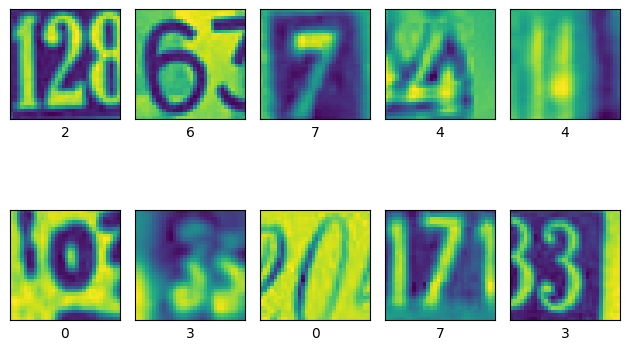

In [55]:
# Interate over range of 10 images
for i in range(10):
  # Show the number image in a subplot along with it's label
  plt.subplot(2, 5, i+1)
  plt.imshow(X_train[i])
  plt.xlabel(y_train[i])

  # Remove X and Y ticks
  plt.xticks([])
  plt.yticks([])


plt.grid(False) # Remove grid
plt.tight_layout() # Remove the dead space
plt.show() # Show the plot

## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [56]:
print(f'Shape of First Image: {X_train[0].shape}')
print('-'*50)
print('First Image Array of Pixels:')
print(X_train[0])

Shape of First Image: (32, 32)
--------------------------------------------------
First Image Array of Pixels:
[[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


### **Normalize the train and the test data**

In [57]:
# Since pixel values range from 0-255, we divide by 255 to get new ranges 0-1
X_train = X_train/255
X_test = X_test/255

Print the shapes of Training and Test data

In [58]:
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')
print('-'*50)
print('First Train Normalized Image Array:')
print(X_train[0])
print('--'*50)
print('First Test Normalized Image Array:')
print(X_test[0])

X_train: (42000, 32, 32), y_train: (42000,), X_test: (18000, 32, 32), y_test: (18000,)
--------------------------------------------------
First Train Normalized Image Array:
[[0.12968785 0.11866706 0.10530196 ... 0.2801847  0.2283153  0.16860352]
 [0.09893451 0.10020902 0.1175549  ... 0.4432192  0.40534863 0.33056822]
 [0.10304902 0.08868118 0.15873058 ... 0.44432473 0.47754902 0.45263842]
 ...
 [0.11196157 0.14200786 0.17678471 ... 0.09465059 0.09840274 0.10219726]
 [0.15072627 0.10381687 0.09126157 ... 0.11023294 0.11556196 0.11790627]
 [0.19724864 0.10226392 0.0942702  ... 0.19477727 0.19942354 0.20799099]]
----------------------------------------------------------------------------------------------------
First Test Normalized Image Array:
[[0.15905097 0.18349686 0.19206432 ... 0.43966785 0.44309962 0.43986115]
 [0.15465844 0.17369059 0.18500705 ... 0.43534195 0.43508825 0.4311247 ]
 [0.1507796  0.1711349  0.19101882 ... 0.4309494  0.43114275 0.42786196]
 ...
 [0.13720353 0.1391007

### **One-hot encode output**

In [59]:
# Get the number of unique categories
class_count = len(np.unique(y_train))

# Encode target variables
y_train = tf.keras.utils.to_categorical(y_train, num_classes = class_count)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=class_count)

**Observation:**

*   Pixel arrays are now normalized to a range from 0-1
*   Training and testing dataset shapes have not changed
*   Target variables are encoded with values 0-9



## **Model Building**

Now that we have done the data preprocessing, let's build an ANN model.

### Fix the seed for random number generators

In [60]:
SEED = 42

# Setting numpy random seed
np.random.seed(SEED)

# Setting python random seed
random.seed(SEED)

# Setting TensorFlow random seed
tf.random.set_seed(SEED)

### **Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **64 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **32 nodes and the relu activation**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_1 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train an ANN model as per the above mentioned architecture.**

In [61]:
def nn_model_1():

  # Initializing the Artificial Neural Network
  model = Sequential([
    Flatten(input_shape=(32, 32)), # A layer to flatten the input
    Dense(64, activation='relu', input_dim=1024),  # A fully connected with 64 nodes as the first layer with input shape (1024,)
    Dense(32, activation='relu'),  # A fully connected with 32 nodes as the second layer
    Dense(class_count, activation='softmax') # An output layer, setting the number of nodes to class_count which is 10
  ])

  # Create an Adam optimizer with a learning rate of 0.001
  optimizer = optimizers.Adam(learning_rate=0.001)

  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

# Creating new ANN model
nn_model = nn_model_1()

# Print the model summary
print(nn_model.summary())

# Fit the model to the train dataset
nn_model_history = nn_model.fit(X_train, y_train,
                                     validation_split = 0.2,
                                     batch_size = 128,
                                     verbose = 1,
                                     epochs = 20)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                65600     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
Total params: 68010 (265.66 KB)
Trainable params: 68010 (265.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
263/263 [==============================] - 2s 5ms/step - loss: 2.2934 - accuracy: 0.1233 - val_loss: 2.2324 - val_accuracy: 0.1744
E

### **Plot the Training and Validation Accuracies and write down your Observations.**

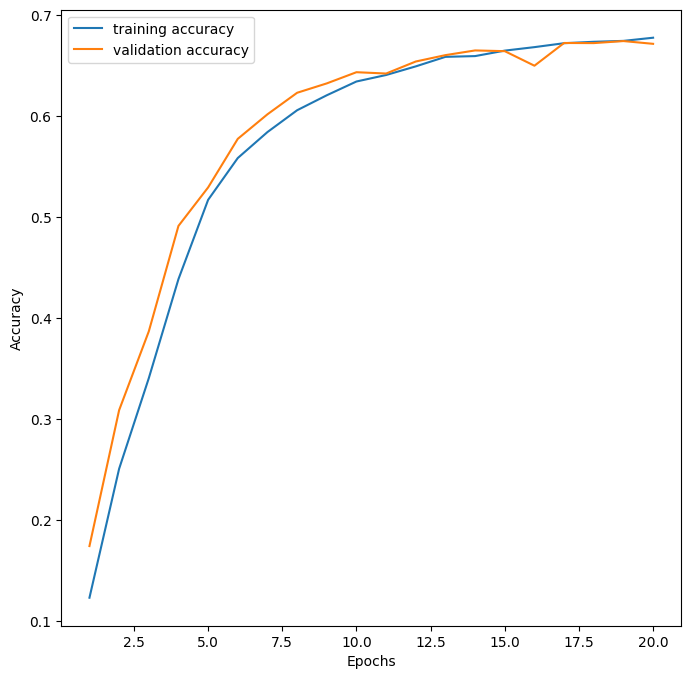

In [62]:
# Dictionary of metrics describing the models fit results
dict_hist = nn_model_history.history

# Range of 20 Epochs
list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

# Plotting the Accuracy and Validation Accuracy
plt.plot(list_ep, dict_hist['accuracy'],  label='training accuracy')
plt.plot(list_ep, dict_hist['val_accuracy'], label='validation accuracy')

# Setting the plot labels
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

# Showing the plot legend
plt.legend()

# Showing the plot
plt.show()

**Observations:**

*   The model has 68,010 trainable parameters
*   The model is getting an accuracy of ~68% for the training data and about ~67% for the validation data.
*   The Training accuracy increases as the epochs increase
*   The Validation accuracy increases, for the most part.




Let's build one more model with higher complexity and see if we can improve the performance of the model.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [63]:
backend.clear_session() # Remove the model for session

# Set the random seeds
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### **Second Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **256 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **128 nodes and the relu activation**
 - Add the **Dropout layer with the rate equal to 0.2**
 - Third hidden layer with **64 nodes and the relu activation**
 - Fourth hidden layer with **64 nodes and the relu activation**
 - Fifth hidden layer with **32 nodes and the relu activation**
 - Add the **BatchNormalization layer**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 -Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.0005), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_2 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the new ANN model as per the above mentioned architecture**

In [64]:
def nn_model_2():
  # Initializing the Artificial Neural Network
  model = Sequential([
    Flatten(input_shape=(32, 32)), # A layer to flatten the input
    Dense(256, activation='relu', input_dim=1024),  # A fully connected layer with 256 nodes as the first layer with input shape (1024,)
    Dense(128, activation='relu'),  # A fully connected layer with 128 nodes as the second layer
    Dropout(0.2), # 20% neurons will be droppped during training to prevent overfitting
    Dense(64, activation='relu'),  # A fully connected with 64 nodes as the third layer
    Dense(64, activation='relu'),  # A fully connected with 64 nodes as the fourth layer
    Dense(32, activation='relu'),  # A fully connected with 32 nodes as the fourth layer
    BatchNormalization(), # Used to improve training speed, stability and generalization performance
    Dense(class_count, activation='softmax') # A Dense layer as output layer, setting the number of nodes to class_count which is 10
  ])

  # Create an Adam optimizer with a learning rate of 0.0005
  optimizer = optimizers.Adam(learning_rate=0.0005)

  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

# Creating new ANN model
nn_model_2 = nn_model_2()

# Print the model summary
print(nn_model_2.summary())

# Fit the model to the train dataset
nn_model_2_history = nn_model_2.fit(X_train, y_train,
                                     validation_split = 0.2,
                                     batch_size = 128,
                                     verbose = 1,
                                     epochs = 30)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2

### **Plot the Training and Validation Accuracies and write down your Observations.**

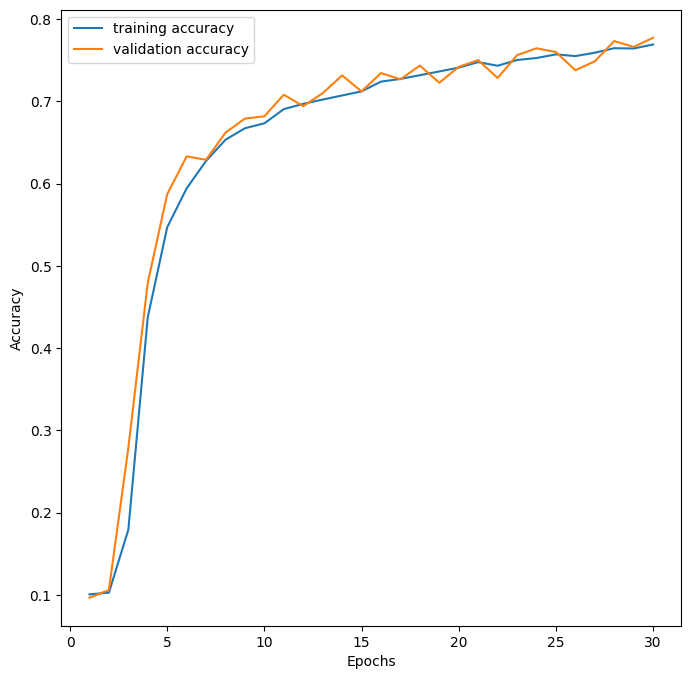

In [65]:
# Dictionary of metrics describing the models fit results
dict_hist = nn_model_2_history.history

# Range of 30 Epochs
list_ep = [i for i in range(1, 31)]

plt.figure(figsize = (8, 8))

# Plotting the Accuracy and Validation Accuracy
plt.plot(list_ep, dict_hist['accuracy'],  label='training accuracy')
plt.plot(list_ep, dict_hist['val_accuracy'], label='validation accuracy')

# Setting the plot labels
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

# Showing the plot legend
plt.legend()

# Showing the plot
plt.show()

**Observations:**

*   The model has 310,186 trainable parameters
*   The model is getting an accuracy of ~79% for the training data and about ~78% for the validation data.
*   The Training accuracy increases as the epochs increase
*   The Validation accuracy increases as the epochs increase

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

In [66]:
pred = nn_model_2.predict(X_test)
pred = np.argmax(pred, axis=-1) # Get the max prediction for each image in the test data

563/563 [==============================] - 1s 2ms/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [67]:
y_true = np.argmax(y_test, axis=1) # Get the max actual labels for each image in the test data

### **Print the classification report and the confusion matrix for the test predictions. Write your observations on the final results.**

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1814
           1       0.81      0.78      0.79      1828
           2       0.78      0.80      0.79      1803
           3       0.70      0.75      0.72      1719
           4       0.80      0.84      0.82      1812
           5       0.76      0.73      0.74      1768
           6       0.80      0.76      0.78      1832
           7       0.79      0.81      0.80      1808
           8       0.78      0.72      0.74      1812
           9       0.72      0.78      0.75      1804

    accuracy                           0.78     18000
   macro avg       0.78      0.78      0.78     18000
weighted avg       0.78      0.78      0.78     18000



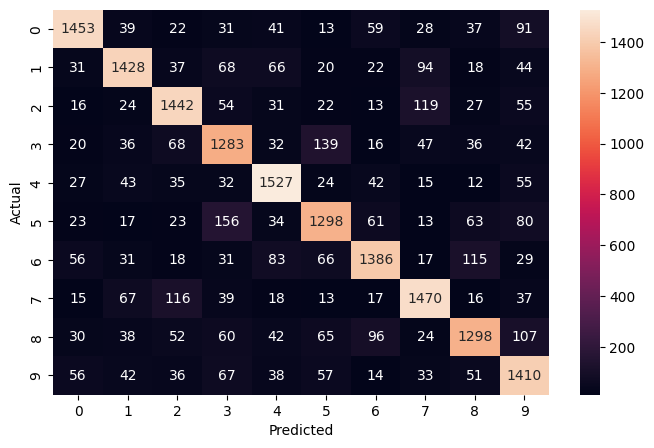

In [68]:
print(classification_report(y_true, pred)) # Showing the Precision, Recall, f1-score etc for each image

cm = confusion_matrix(y_true, pred)

class_names = range(0, 10) # Creating a list of class names

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot=True, fmt='.0f',xticklabels = class_names, yticklabels=class_names) # Plotting heatmap to show the confusion matrix

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

**Final Observations:**

*   4, 7, and 0 have the highest f1-score.
*   3 has the lowest recall.
*   3 has the lowest precision.
*   According to the confusion matrix the model often mistakes a 5 for a 3.  Which kind of makes sense.
*   The model also often mistakes a 2 for a 7.  Which also makes sense.
*   The overall accuracy is 78%



## **Using Convolutional Neural Networks**

### **Load the dataset again and split the data into the train and the test dataset.**

In [69]:
# Load file
dataset = h5py.File(H5_FILE_PATH, 'r')

# Set the image train and test datasets
X_train = dataset['X_train'][:]
X_test = dataset['X_test'][:]

# Set the label train and test datasets
y_train = dataset['y_train'][:]
y_test = dataset['y_test'][:]

Check the number of images in the training and the testing dataset.

In [70]:
X_train.shape, X_test.shape # getting the shape of the train and test datasets

((42000, 32, 32), (18000, 32, 32))

**Observation:**

*   There are 42,000 32x32 images in the training dataset
*   There are 18,000 32x32 images in the test dataset


## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Reshape the train and the test dataset because we always have to give a 4D array as input to CNNs.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [71]:
print(f'Shape of First Image: {X_train[0].shape}')
print('-'*50)
print('First Image Array of Pixels:')
print(X_train[0])

Shape of First Image: (32, 32)
--------------------------------------------------
First Image Array of Pixels:
[[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


Reshape the dataset to be able to pass them to CNNs. Remember that we always have to give a 4D array as input to CNNs

In [72]:
channels = 1 # for grayscale images

# Reshape the dataset to add a channel dimension
X_train_4d = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], channels))
X_test_4d = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], channels))

Normalize inputs from 0-255 to 0-1

In [73]:
# Since pixel values range from 0-255, we divide by 255 to get new ranges 0-1
X_train_4d = X_train_4d/255
X_test_4d = X_test_4d/255

Print New shape of Training and Test

In [74]:
print(f'X_train: {X_train_4d.shape}, X_test: {X_test_4d.shape}')

X_train: (42000, 32, 32, 1), X_test: (18000, 32, 32, 1)


### **One-hot encode the labels in the target variable y_train and y_test.**

In [75]:
# Get the number of unique categories
class_count = len(np.unique(y_train))

# Encode target variables
y_train = tf.keras.utils.to_categorical(y_train, num_classes = class_count)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=class_count)

**Observation:**

*   X_train and X_test are reshape to include a grayscale channel
*   Pixel arrays are now normalized to a range from 0-1
*   Target variables are encoded with values 0-9

## **Model Building**

Now that we have done data preprocessing, let's build a CNN model.
Fix the seed for random number generators

In [76]:
backend.clear_session() # Remove the model for session

# Set the random seeds
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### **Model Architecture**
- **Write a function** that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Another **LeakyRelu** with the **slope equal to 0.1**
 - A **max-pooling layer** with a **pool size of 2x2**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_1 and store the output in a new variable.
- Print the summary of the model.
- Fit the model on the training data with a **validation split of 0.2, batch size = 32, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train a CNN model as per the above mentioned architecture.**

In [77]:
def cnn_model_1():
  # Initializing the Convolutional Neural Network
  model = Sequential([
      Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32, 32, 1)), # Convolutional input layer with 16 filters
      LeakyReLU(alpha=0.1), # Applying LeakyReLU activation function to introduce non-linearity and mitigate the dying ReLU problem (output is zero for all inputs)
      Conv2D(32, (3,3), padding='same', activation='relu'),
      LeakyReLU(alpha=0.1),
      MaxPooling2D(2,2), # Used to downsample the feature maps, reducing computational complexity and controlling overfitting
      Flatten(), # Converts the 2D feature maps into a 1D vector for feeding into the fully connected layers
      Dense(32, activation='relu'), # Fully connected layer with 32 neurons and ReLU activation function
      LeakyReLU(alpha=0.1),
      Dense(class_count, activation='softmax') # Output layer with 10 nodes which is the number of classes
  ])

  # Create an Adam optimizer with a learning rate of 0.001
  optimizer = optimizers.Adam(learning_rate=0.001)

  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

# Creating new ANN model
cnn_model = cnn_model_1()

# Print the model summary
print(cnn_model.summary())

# Fit the model to the train dataset
cnn_model_history = cnn_model.fit(X_train_4d, y_train,
                                     validation_split = 0.2,
                                     batch_size = 32,
                                     verbose = 1,
                                     epochs = 20)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                        

### **Plot the Training and Validation Accuracies and Write your observations.**

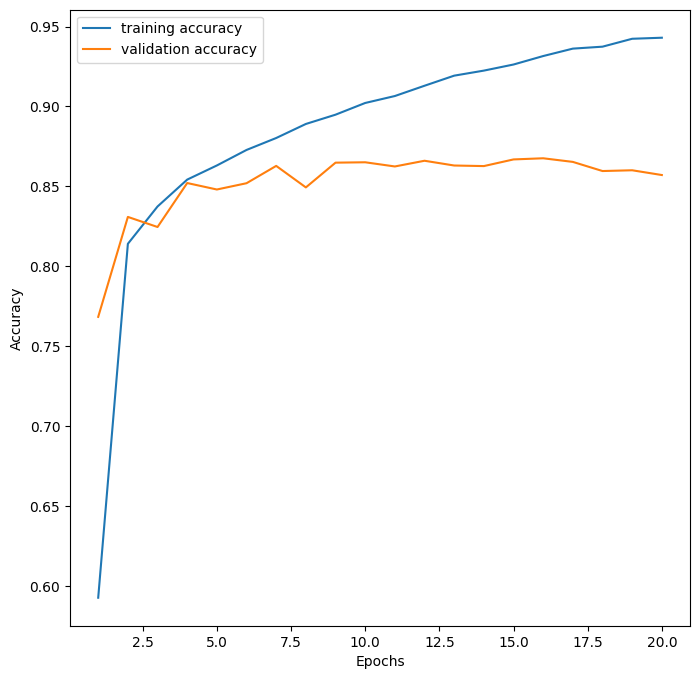

In [78]:
# Dictionary of metrics describing the models fit results
dict_hist = cnn_model_history.history

# Range of 20 Epochs
list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

# Plotting the Accuracy and Validation Accuracy
plt.plot(list_ep, dict_hist['accuracy'],  label='training accuracy')
plt.plot(list_ep, dict_hist['val_accuracy'], label='validation accuracy')

# Setting the plot labels
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

# Showing the plot legend
plt.legend()

# Showing the plot
plt.show()

**Observations:**
*   The model has 267,306 trainable parameters
*   The training accuracy is ~94% which is higher than the ANN models.
*   The validation accuracy is ~86% which is also higher that then ANN models.
*   The constant increase of the training accuracy compiled with the decrease of the validation accuracy indicates that the model is **overfitting**
*   The Training accuracy increases as the epochs increase
*   The Validation accuracy levels off around early in the epochs around epoch 2.

Let's build another model and see if we can get a better model with generalized performance.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [79]:
backend.clear_session() # Remove the model for session

# Set the random seeds
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### **Second Model Architecture**

- Write a function that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add **LeakyRelu** with the **slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - Third Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Fourth Convolutional layer **64 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **dropout layer with the rate equal to 0.5**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_2 and store the model in a new variable.
- Print the summary of the model.
- Fit the model on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the second CNN model as per the above mentioned architecture.**

In [80]:
def cnn_model_2():
  # Initializing the Convolutional Neural Network
  model = Sequential([
      Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32, 32, 1)), # Convolutional input layer with 16 filters
      LeakyReLU(alpha=0.1), # Applying LeakyReLU activation function to introduce non-linearity and mitigate the dying ReLU problem (output is zero for all inputs)
      Conv2D(32, (3,3), padding='same', activation='relu'),
      LeakyReLU(alpha=0.1),
      MaxPooling2D(2,2), # Used to downsample the feature maps, reducing computational complexity and controlling overfitting
      BatchNormalization(), # Used to normalize the activations and stabilize the training process which can accerlerate the training process
      Conv2D(32, (3,3), padding='same', activation='relu'),
      LeakyReLU(alpha=0.1),
      Conv2D(64, (3,3), padding='same', activation='relu'),
      LeakyReLU(alpha=0.1),
      MaxPooling2D(2,2),
      BatchNormalization(),
      Flatten(), # Converts the 2D feature maps into a 1D vector for feeding into the fully connected layers
      Dense(32, activation='relu'), # Fully connected layer with 32 neurons and ReLU activation function
      LeakyReLU(alpha=0.1),
      Dropout(0.5), # Drops 50 precent the neurons to reduce overfitting
      Dense(class_count, activation='softmax') # Output layer with 10 nodes which is the number of classes
  ])

  # Create an Adam optimizer with a learning rate of 0.001
  optimizer = optimizers.Adam(learning_rate=0.001)

  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

# Creating new ANN model
cnn_model_v2 = cnn_model_2()

# Print the model summary
print(cnn_model_v2.summary())

# Fit the model to the train dataset
cnn_model_2_history = cnn_model_v2.fit(X_train_4d, y_train,
                                     validation_split = 0.2,
                                     batch_size = 128,
                                     verbose = 1,
                                     epochs = 30)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                         

### **Plot the Training and Validation accuracies and write your observations.**

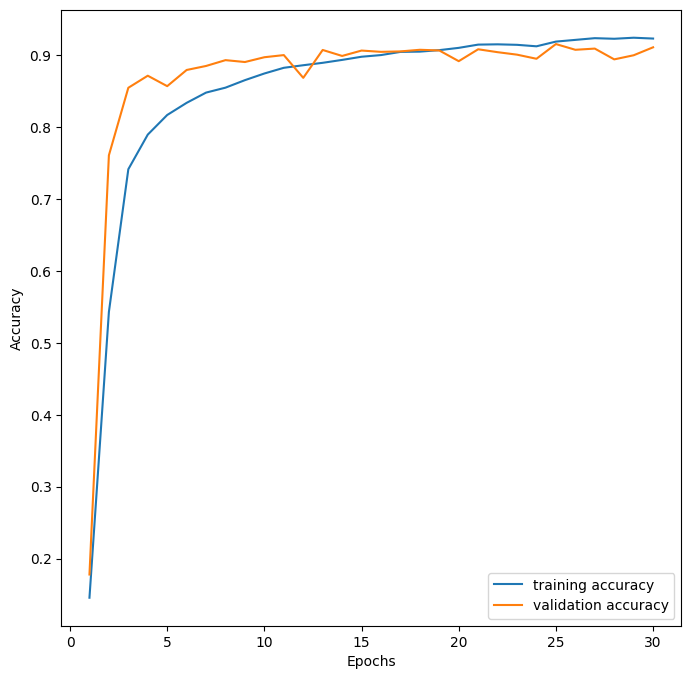

In [81]:
# Dictionary of metrics describing the models fit results
dict_hist = cnn_model_2_history.history

# Range of 30 Epochs
list_ep = [i for i in range(1, 31)]

plt.figure(figsize = (8, 8))

# Plotting the Accuracy and Validation Accuracy
plt.plot(list_ep, dict_hist['accuracy'],  label='training accuracy')
plt.plot(list_ep, dict_hist['val_accuracy'], label='validation accuracy')

# Setting the plot labels
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

# Showing the plot legend
plt.legend()

# Showing the plot
plt.show()

**Observations:**
*   The model has 164,170 trainable parameters
*   The training accuracy is ~92% which is slightly lower than the first CNN model.
*   The validation accuracy is ~91% which is higher than the first CNN model.
*   There is a steady increase in both training and validation accuracies until around epoch 17.  So it seems after epoch ~17 the model begins to overfit a little.
*   The model especially at epoch 17 is performing better than all the others model so far.

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

### **Make predictions on the test data using the second model.**

In [82]:
pred_2 = cnn_model_v2.predict(X_test)
pred_2 = np.argmax(pred_2, axis=-1) # Get the max prediction for each image in the test data

563/563 [==============================] - 1s 2ms/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector, but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [83]:
y_true = np.argmax(y_test, axis=1) # Get the max actual labels for each image in the test data

### **Write your final observations on the performance of the model on the test data.**

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1814
           1       0.88      0.76      0.82      1828
           2       0.82      0.86      0.84      1803
           3       0.67      0.83      0.75      1719
           4       0.86      0.83      0.85      1812
           5       0.68      0.92      0.78      1768
           6       0.78      0.71      0.74      1832
           7       0.89      0.86      0.88      1808
           8       0.86      0.69      0.77      1812
           9       0.82      0.77      0.79      1804

    accuracy                           0.80     18000
   macro avg       0.81      0.80      0.80     18000
weighted avg       0.81      0.80      0.80     18000



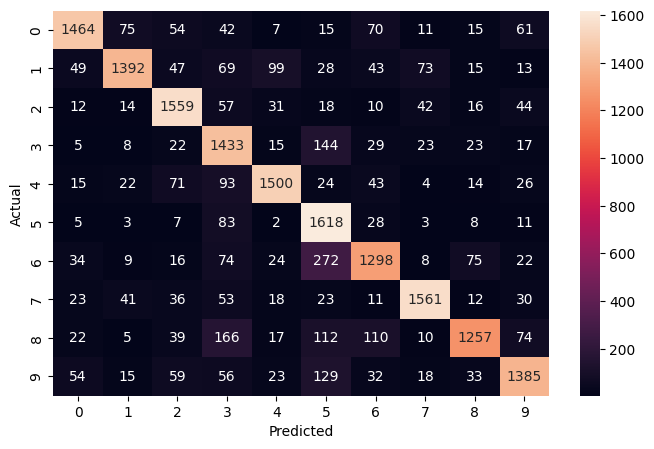

In [84]:
print(classification_report(y_true, pred_2)) # Showing the Precision, Recall, f1-score etc for each image

cm = confusion_matrix(y_true, pred_2)

class_names = range(0, 10) # Creating a list of class names

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot=True, fmt='.0f',xticklabels = class_names, yticklabels=class_names) # Plotting heatmap to show the confusion matrix

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

**Final Observations:**
*   7 and 4 have the highest f1-score
*   8 has the lowest recall
*   3 has the lowest precision
*   According to the confusion matrix the model often mistakes a 6 for a 5.
*   Another mistake thinking a 8 is a 3.  But much less than 6 and 5.
*   The overall accuracy is 80%

### **This is extra but I will like to visualize the models predictions**

563/563 [==============================] - 2s 3ms/step


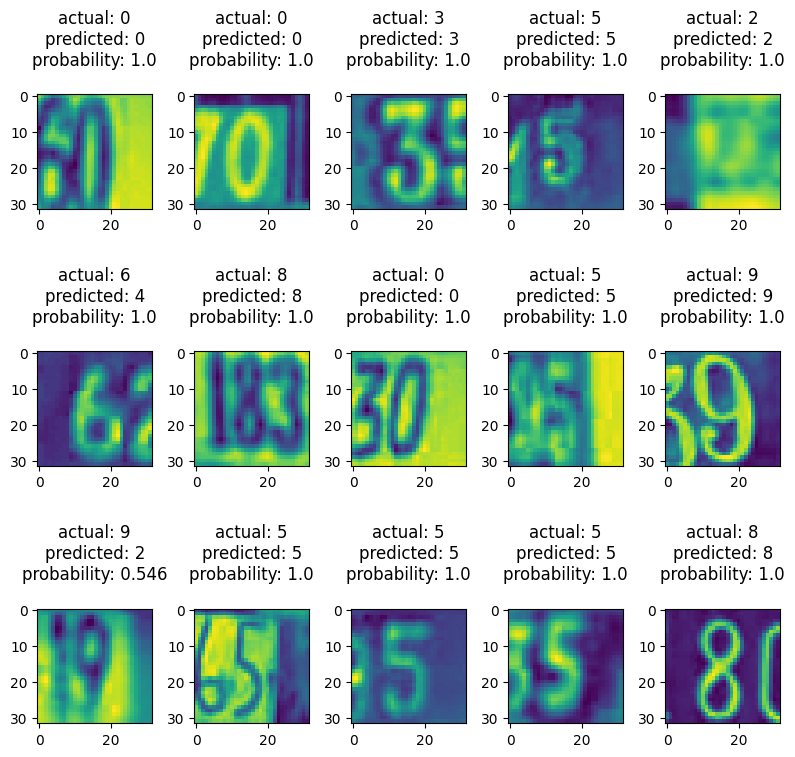

In [90]:
rows = 3
cols = 5
class_names = range(0, 15) # Creating a list of class names

fig = plt.figure(figsize = (8,8)) # Creating a plot space for the images

for i in range(cols):
  for j in range(rows):

    random_index = np.random.randint(0, len(y_test)) # Selecting a random index

    ax = fig.add_subplot(rows, cols, i * rows + j + 1) # Creating a subplot

    ax.imshow(X_test[random_index, :]) # Selecting a random image array

    pred_label = class_names[pred_2[random_index]] # Getting the selected image predicted label

    true_label = class_names[y_true[random_index]] # Getting the selected image actual label

    y_pred_test_max_probas = np.max(cnn_model_v2.predict(X_test), axis=1) # Getting the maximum predictions

    pred_proba = y_pred_test_max_probas[random_index] # Getting prediction for the selected image

    # Printing actual label, predicted label, and probability using a formatted string
    ax.set_title('actual: {}\npredicted: {}\nprobability: {:.3}\n'.format(
        true_label, pred_label, pred_proba
    ))


plt.grid(False) # Remove grid
plt.tight_layout() # Remove the dead space
plt.show() # Show the plot

**Observations:**
*   You can see the model does very well on clear images of numbers
*   It's kind of guessing on the less clear images as you can see that it's 55% sure that the 9 is a 2.

## **Conclusion**

- I trained 4 different models with them getting more and more complicated.
- First ANN model is doing well on not overfitting and has an accuracy of 68% on the training data and 67% on the valdation data.
- The second ANN model which have more hidden layers along with Batch Normalization and Dropout layers.  It also does not seem to overfit and has an accuracy of 77% on the training data and 78% on the validation data.
- The next model is the first CNN model which has a clear issue of overfitting.  But also has higher accuracies with 94% on the training data and 86% on the validation data.
- The last model is a more complicated CNN model with more hidden, LeakyReLU, and Dropout layers.  It is doing a lot better on generalizing and not overfitting.  It has accuracy of 92% on the training data and 91% on the validation data.
- **The last CNN model, cnn_model_v2, is the model I recommend** using because of its high accuracy on the training and validation data and its greater ability to generalize.  Which means it will perform well on unseen data.
- Finally, I visualized some of the images from the test data.  It's always nice to see the model's predictions on the images.